# Importing data and libraries

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle

def read_edf(filename):
    data = mne.io.read_raw_edf(filename)
    raw_data = data.get_data()
    # you can get the metadata included in the file and a list of all channels:
    # info = data.info
    channels = data.ch_names
  
    return raw_data, channels

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
path='C:\\Users\\user\\Desktop\\Manuscript_Projects_IISERTVM\\EEG data\\dataset'

In [4]:
exclude_patients = ['40','41','69','2','3']

In [5]:
# Read annotations

annotation_path_A = path + '\\annotations_2017_A.csv'
annotation_path_B = path + '\\annotations_2017_B.csv'
annotation_path_C = path + '\\annotations_2017_C.csv'

annotation_data_A = pd.read_csv(annotation_path_A)
annotation_data_B = pd.read_csv(annotation_path_B)
annotation_data_C = pd.read_csv(annotation_path_C)

annotation_data_A=annotation_data_A.drop(exclude_patients,axis=1)
annotation_data_B=annotation_data_B.drop(exclude_patients,axis=1)
annotation_data_C=annotation_data_C.drop(exclude_patients,axis=1)


annotation_data_dict={'A':annotation_data_A,'B':annotation_data_B,'C':annotation_data_C}

# Extracting data for pre-seizure vs non-pre seizure chunks

In [6]:
def get_seizure_seconds_for_patient_i_doctor_j(i,j):
    "i can take value in range(0,79) while j can take value among A, B or C"
    "For patient i and doctor j this function gives us the all the non seizure seconds"
    annotation_data =annotation_data_dict[j]
    annotation_data_patient_i=np.array(annotation_data_A[str(i)])
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(annotation_data_patient_i)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if annotation_data_patient_i[i]==annotation_data_patient_i[i+1] and annotation_data_patient_i[i]==1:
            single_chunk.append(i)
        else:
            flag=True
            single_chunk.append(i)
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

In [7]:
def get_non_seizure_seconds_for_patient_i_doctor_j(i,j):
    "i can take value in range(0,79) while j can take value among A, B or C"
    "For patient i and doctor j this function gives us the all the non seizure seconds"
    annotation_data =annotation_data_dict[j]
    annotation_data_patient_i=np.array(annotation_data_A[str(i)])
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(annotation_data_patient_i)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if annotation_data_patient_i[i]==annotation_data_patient_i[i+1] and annotation_data_patient_i[i]==0:
            single_chunk.append(i)
        else:
            flag=True
            single_chunk.append(i)
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

In [8]:
def get_non_seizure_seconds_for_patient_i_all_doctors(i):
    "For patient i this function gives us the all the non seizure seconds that all doctors agree upon"
    A=get_non_seizure_seconds_for_patient_i_doctor_j(i,'A')
    B=get_non_seizure_seconds_for_patient_i_doctor_j(i,'B')
    C=get_non_seizure_seconds_for_patient_i_doctor_j(i,'C')
    A_B_C_agrees=np.array(list((set(np.concatenate(A)).intersection(np.concatenate(B))).intersection(np.concatenate(C))))
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(A_B_C_agrees)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if A_B_C_agrees[i]+1==A_B_C_agrees[i+1]:
            single_chunk.append(A_B_C_agrees[i])
        else:
            flag=True
            single_chunk.append(A_B_C_agrees[i])
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

In [9]:
all_patient_indices=np.array(annotation_data_A.columns,dtype="int64")

In [10]:
np.random.seed(42)
shuffle_perm=np.random.permutation(list(range(len(all_patient_indices))))
all_patient_indices=all_patient_indices[shuffle_perm]
training_patients=all_patient_indices[:65]
validation_patients=all_patient_indices[65:]

In [11]:
training_patients

array([ 7, 68, 21,  1, 31, 79, 13, 37, 15, 60, 71, 34, 12, 50,  8, 25, 62,
       55, 36, 44, 76, 19, 38, 49, 66, 10, 61, 47, 33, 52, 54, 22, 64, 28,
       45, 16, 58,  6, 20, 43, 11, 63,  9, 39, 73, 59, 51, 78, 18, 30, 46,
       29, 53, 27, 67, 72, 14, 35, 75, 70, 42, 32, 48, 74,  4],
      dtype=int64)

In [12]:
validation_patients

array([57, 24,  5, 26, 23, 65, 77, 17, 56], dtype=int64)

In [13]:
non_seizure_chunk_lengths=[]
for patient in training_patients:
    non_seizure_chunks=get_non_seizure_seconds_for_patient_i_all_doctors(patient)
    for chunk in non_seizure_chunks: 
        non_seizure_chunk_lengths.append(len(chunk))

In [14]:
len(np.array(non_seizure_chunk_lengths)[np.where(np.array(non_seizure_chunk_lengths)>=20)[0]])

269

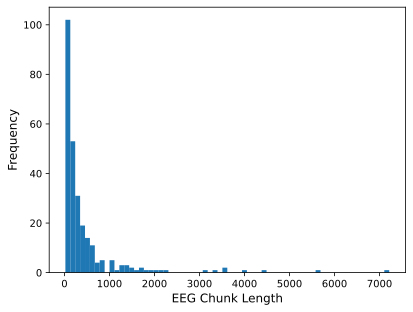

In [15]:
plt.hist(np.array(non_seizure_chunk_lengths)[np.where(np.array(non_seizure_chunk_lengths)>=20)[0]], bins='auto') 
plt.xlabel("EEG Chunk Length",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

In [16]:
def get_pre_seizure_chunks(chunk_length=60,padding_before_seizure=60):
    "This function extracts chunks of pre seizure seconds for a given chunk length and padding length before seizure starts"
    pre_seizure_chunks_for_patients=[]
    patient_index=[]
    for patient in training_patients:
        chunks=get_non_seizure_seconds_for_patient_i_all_doctors(patient)
        for chunk in chunks:
            if len(chunk)-padding_before_seizure>chunk_length:
                sample_pre_seizure_chunks_for_patient_i=chunk[-chunk_length:]
                pre_seizure_chunks_for_patients.append(np.array(sample_pre_seizure_chunks_for_patient_i))
                patient_index.append(patient)
    return np.array(pre_seizure_chunks_for_patients), np.array(patient_index)

In [17]:
pre_seizure_chunks, patient_index=get_pre_seizure_chunks(chunk_length=20,padding_before_seizure=0)

In [18]:
pre_seizure_chunks.shape

(269, 20)

In [19]:
def get_non_pre_seizure_chunks(chunk_length=60,padding_before_seizure=60):
    "This function extracts chunks of non pre seizure seconds for a given chunk length and padding length before seizure starts"
    non_pre_seizure_chunks_for_patients=[]
    patient_index=[]
    for patient in training_patients:
        rough_non_pre_seiure_chunks_patient_i=np.array([chunk[:-(chunk_length+padding_before_seizure)] for chunk in get_non_seizure_seconds_for_patient_i_all_doctors(patient)],dtype='object')
        for big_chunk in rough_non_pre_seiure_chunks_patient_i:
            if len(big_chunk)>chunk_length:
                stating_point=0
                ending_point=chunk_length
                num_chunks=len(big_chunk)//chunk_length
                for i in range(num_chunks):
                    small_chunk=big_chunk[stating_point:ending_point]
                    stating_point+=chunk_length
                    ending_point+=chunk_length
                    non_pre_seizure_chunks_for_patients.append(small_chunk)
                    patient_index.append(patient)
    return np.array(non_pre_seizure_chunks_for_patients), np.array(patient_index)

In [20]:
non_pre_seizure_chunks, non_patient_index=get_non_pre_seizure_chunks(chunk_length=20,padding_before_seizure=120)

In [21]:
non_pre_seizure_chunks.shape

(4467, 20)

In [22]:
def get_seizure_chunks_single_patient(patient_index,chunk_length=60):
    ##patient i index i-1
    doctor_A_ann_for_pat=np.array(annotation_data_A[str(patient_index)])
    doctor_B_ann_for_pat=np.array(annotation_data_B[str(patient_index)])
    doctor_C_ann_for_pat=np.array(annotation_data_C[str(patient_index)])
    
    common_seizure_points=doctor_A_ann_for_pat*doctor_B_ann_for_pat*doctor_C_ann_for_pat
    all_chunks=[]
    for i in range(len(common_seizure_points)-1):
        if common_seizure_points[i]==common_seizure_points[i+1] and common_seizure_points[i]==1:
            all_chunks.append(i)
    
    chunks_separated=[]
    start_index=0
    for i in range(len(all_chunks)-1):
        if all_chunks[i]+1!=all_chunks[i+1]:
            if len(all_chunks[start_index:i])>=chunk_length:
                chunks_separated.append(all_chunks[start_index:i])
            start_index=i+1
            
    sampled_chunks=[]
    for i in chunks_separated:
        num_chunks=len(i)//chunk_length
        count=1
        while count<=num_chunks:
            sampled_chunks.append(i[(count-1)*chunk_length:count*chunk_length])
            count+=1
    return np.array(sampled_chunks)

In [23]:
def get_seizure_chunks_for_all_patients():
    chunks_of_single_patient = []
    seizure_patient_indices = []
    for patient_index in training_patients:
        seizure_chunks_single_patient=get_seizure_chunks_single_patient(patient_index,chunk_length=20)
        if len(seizure_chunks_single_patient)>0:
            for i in range(len(seizure_chunks_single_patient)):
                seizure_patient_indices.append(patient_index)
            chunks_of_single_patient.append(seizure_chunks_single_patient)     
    return np.concatenate(np.array(chunks_of_single_patient,dtype=object)), np.array(seizure_patient_indices)

In [24]:
seizure_chunks, seizure_patient_index=get_seizure_chunks_for_all_patients()

In [25]:
seizure_chunks.shape

(838, 20)

In [26]:
pre_seizure_chunks.shape

(269, 20)

In [27]:
non_pre_seizure_chunks.shape

(4467, 20)

# Mapping to EEG data:

In [28]:
with open('all_ICA_preprocessed_EEG_data.pkl', 'rb') as f:
    all_ICA_preprocessed_EEG_data = pickle.load(f)

In [29]:
all_patient_indices=np.array(annotation_data_A.columns,dtype="int64")

In [30]:
patient_eeg_dict={}
count=0
for pat_index in all_patient_indices:
    patient_eeg_dict[pat_index]=all_ICA_preprocessed_EEG_data[count]
    count=count+1

In [31]:
# Mapping the pre-Seizure chunks into the EEG dataset: Chunk length=60, Padding before seizure=60

path='C:\\Users\\user\\Desktop\\Manuscript_Projects_IISERTVM\\EEG data\\dataset'
eeg_data_pre_seizure = []

for chunk in range(len(pre_seizure_chunks)):
    patient_id = patient_index[chunk]
    sigbufs=patient_eeg_dict[patient_id]
    n_channels = len(sigbufs)
    eeg_channels_data = []
    for i in range(n_channels):
        eeg_signal = sigbufs[i][256*pre_seizure_chunks[chunk][0]:256*(pre_seizure_chunks[chunk][-1]+1)]
        eeg_channels_data.append((eeg_signal))
    eeg_data_pre_seizure.append(np.array(eeg_channels_data))
    
print(len(eeg_data_pre_seizure))


269


In [32]:
# Mapping the Seizure chunks into the EEG dataset: Chunk length=60, Padding before seizure=60

path='C:\\Users\\user\\Desktop\\Manuscript_Projects_IISERTVM\\EEG data\\dataset'
eeg_data_seizure = []

for chunk in range(len(seizure_chunks)):
    patient_id = seizure_patient_index[chunk]
    sigbufs=patient_eeg_dict[patient_id]
    n_channels = len(sigbufs)
    eeg_channels_data = []
    for i in range(n_channels):
        eeg_signal = sigbufs[i][256*seizure_chunks[chunk][0]:256*(seizure_chunks[chunk][-1]+1)]
        eeg_channels_data.append((eeg_signal))
    eeg_data_seizure.append(np.array(eeg_channels_data))
    
print(len(eeg_data_seizure))


838


In [33]:
# Mapping the non-pre-Seizure chunks into the EEG dataset.
path='C:\\Users\\user\\Desktop\\Manuscript_Projects_IISERTVM\\EEG data\\dataset'
eeg_data_non_pre_seizure = []

for chunk in range(len(non_pre_seizure_chunks)):
    patient_id = non_patient_index[chunk]
    sigbufs=patient_eeg_dict[patient_id]
    n_channels = len(sigbufs)
    eeg_channels_data = []
    for i in range(n_channels):
        eeg_signal = sigbufs[i][256*non_pre_seizure_chunks[chunk][0]:256*(non_pre_seizure_chunks[chunk][-1]+1)]
        eeg_channels_data.append((eeg_signal))
    eeg_data_non_pre_seizure.append(np.array(eeg_channels_data))
    
print(len(eeg_data_non_pre_seizure))

4467


In [34]:
eeg_data_pre_seizure=np.array(eeg_data_pre_seizure)
eeg_data_non_pre_seizure=np.array(eeg_data_non_pre_seizure)
eeg_data_seizure=np.array(eeg_data_seizure)

In [35]:
eeg_data_seizure.shape

(838, 19, 5120)

In [36]:
eeg_data_pre_seizure.shape

(269, 19, 5120)

In [37]:
eeg_data_non_pre_seizure.shape

(4467, 19, 5120)

## Combined pre-seizure data

In [38]:
eeg_data_pre_seizure_combined=[]
for gap in tqdm(range(0,110,10)):
    pre_seizure_chunks, patient_index=get_pre_seizure_chunks(chunk_length=20,padding_before_seizure=gap)
    path='C:\\Users\\user\\Desktop\\Manuscript_Projects_IISERTVM\\EEG data\\dataset'
    eeg_data_pre_seizure = []
    
    for chunk in range(len(pre_seizure_chunks)):
        patient_id = patient_index[chunk]
        sigbufs=patient_eeg_dict[patient_id]
        n_channels = len(sigbufs)
        eeg_channels_data = []
        for i in range(n_channels):
            eeg_signal = sigbufs[i][256*pre_seizure_chunks[chunk][0]:256*(pre_seizure_chunks[chunk][-1]+1)]
            eeg_channels_data.append((eeg_signal))
        eeg_data_pre_seizure.append(np.array(eeg_channels_data))

    eeg_data_pre_seizure=np.array(eeg_data_pre_seizure)
    eeg_data_pre_seizure_combined.append(eeg_data_pre_seizure)
eeg_data_pre_seizure_combined=np.concatenate(eeg_data_pre_seizure_combined)

100%|██████████| 11/11 [00:15<00:00,  1.38s/it]


In [39]:
eeg_data_pre_seizure_combined.shape

(2414, 19, 5120)

In [40]:
np.save('ica_eeg_data_pre_seizure.npy', eeg_data_pre_seizure_combined)
np.save('ica_eeg_data_non_pre_seizure.npy', eeg_data_non_pre_seizure)
np.save('ica_eeg_data_seizure.npy', eeg_data_seizure)

# Vizualizing Seizure vs Non-Seizure chunks

In [41]:
def vizualize_eeg_channels(signal,offset=0.0005):
    # Set the number of channels and the offset between each channel
    n_channels = len(signal)
    offset = 0.0005
    
    # Set the left and right margins for the window in which we want to plot the data at
    
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot each signal with an offset
    for i in range(n_channels): # Remove the EKG and Effor
        ax.plot(signal[i] + i * offset)
    
    # Set the y-axis labels to the signal labels
    ax.set_yticks(np.arange(n_channels) * offset)
    #ax.set_yticklabels(signal_labels)
    
    # Set the x-axis label
    ax.set_xlabel("Time")
    
    # Add a legend
    #plt.legend()
    
    # Show the plot
    plt.show()


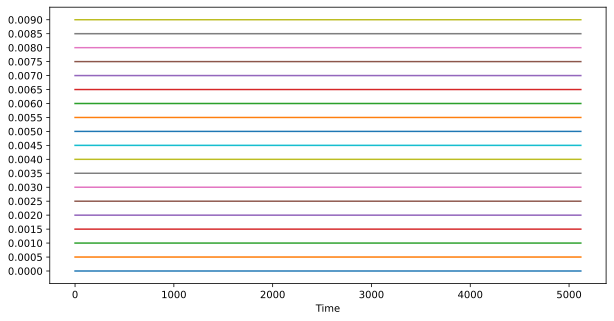

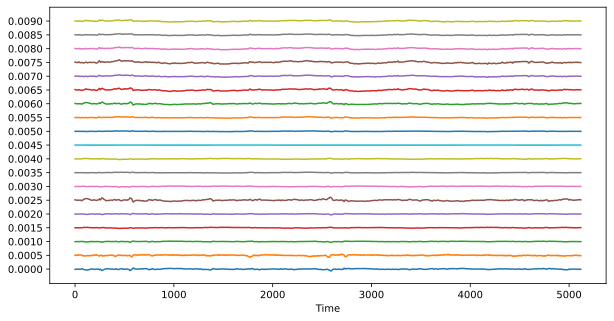

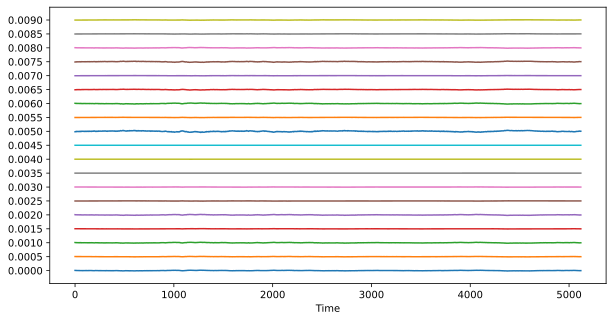

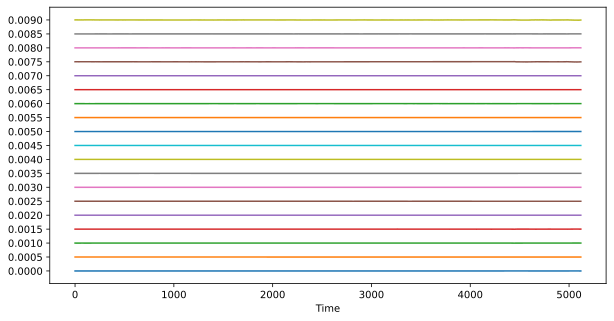

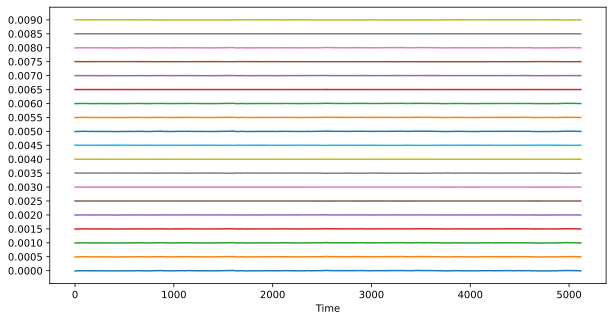

In [42]:
## vizualize pre seizure patterns
for i in range(5):
    vizualize_eeg_channels(eeg_data_pre_seizure[random.randint(0,len(eeg_data_pre_seizure))],offset=0.0005)

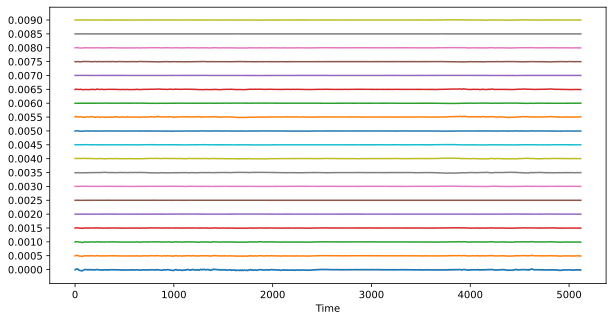

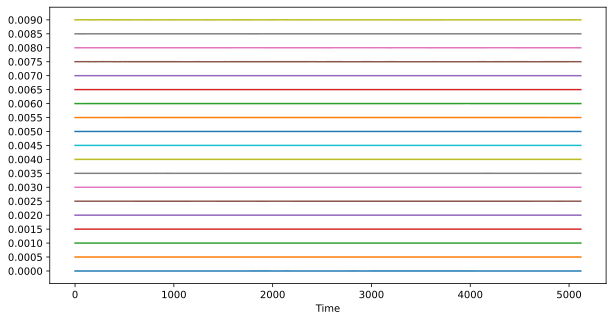

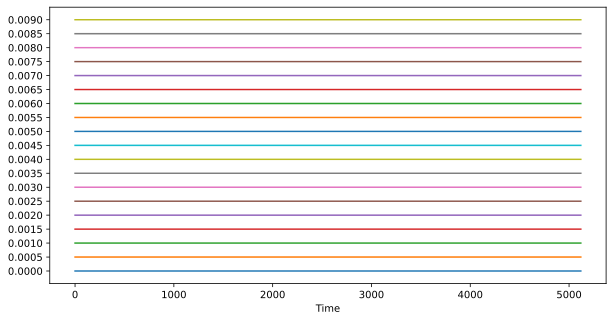

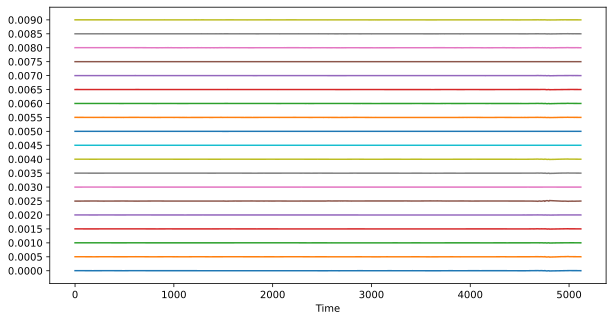

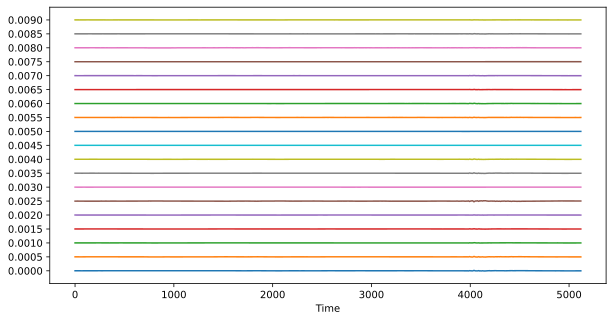

In [43]:
## vizualize pre seizure patterns
for i in range(5):
    vizualize_eeg_channels(eeg_data_non_pre_seizure[random.randint(0,len(eeg_data_non_pre_seizure))],offset=0.0005)

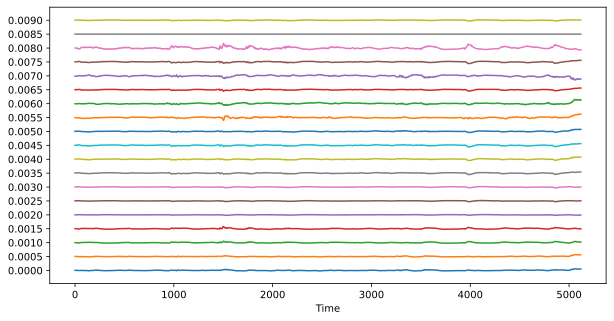

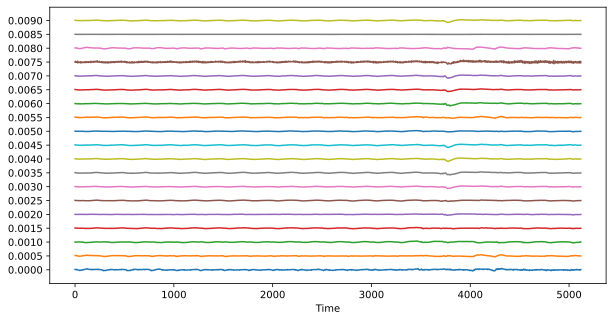

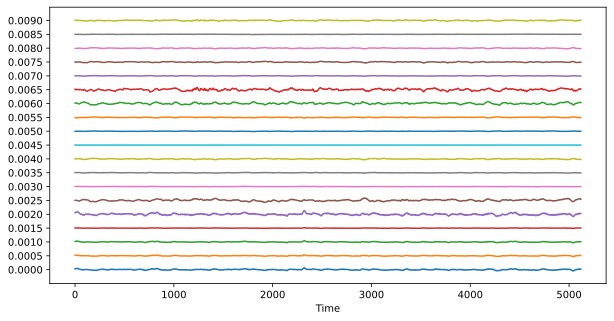

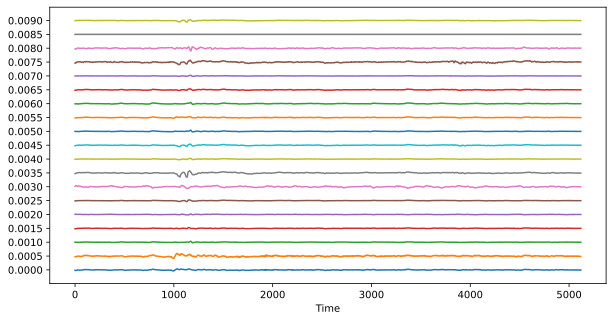

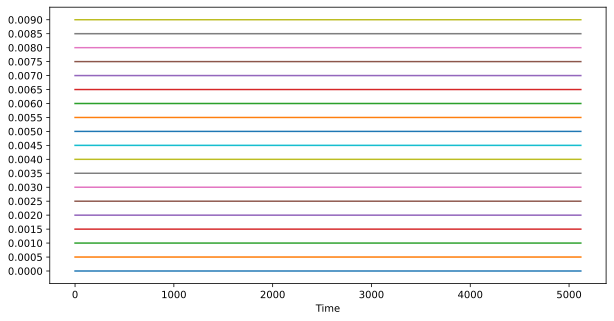

In [44]:
## vizualize pre seizure patterns
for i in range(5):
    vizualize_eeg_channels(eeg_data_seizure[random.randint(0,len(eeg_data_seizure))],offset=0.0005)

In [46]:
validation_sigbufs=[]
for patient_index in validation_patients:
    sigbufs=patient_eeg_dict[patient_index]
    validation_sigbufs.append(sigbufs)

In [47]:
def get_second_wise_stats_patient_channel(X,chunk):
    chunk_embedding=[]
    for channel in range(19):
        mean=np.mean(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        std=np.mean(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        min_=np.min(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        max_=np.max(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        median=np.median(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        info=np.array([mean,std,min_,max_,median])
        chunk_embedding.append(info)
    chunk_embedding=np.array(chunk_embedding)
    return np.concatenate(chunk_embedding)

In [48]:
def scale_eeg(X):
    return np.array([np.array([(X[index][channel]-np.min(X[index][channel]))/(np.max(X[index][channel])-np.min(X[index][channel])+0.000001) for channel in range(X.shape[1])]) for index in range(len(X))])

In [49]:
def get_patient_wise_chunks_val(val_patient_index,gap=1,chunk_length=20):
    ##This functions takes the entire eeg duration as input and breaks it down to chunks of 60 secs with a gap of 3 secs
    k=np.where(validation_patients==val_patient_index)[0][0]
    single_patient_data=validation_sigbufs[k][:19,:]
    starting_point=0
    Hertz=256
    collect_chunks=[]
    while starting_point+256*chunk_length< single_patient_data.shape[1]:
        chunk=single_patient_data[:,starting_point:starting_point+Hertz*chunk_length]
        starting_point=starting_point+gap*Hertz
        collect_chunks.append(chunk)
    collect_chunks=np.array(collect_chunks)
    
    X_reduced_len_val_patient_chunks=[]
    for i in tqdm(range(len(collect_chunks))):
        X_reduced_len_val_patient_chunks.append(get_second_wise_stats_patient_channel(collect_chunks,i))
    X_reduced_len_val_patient_chunks=np.array(X_reduced_len_val_patient_chunks)
    
    X_reduced_len_val_patient_chunks=scale_eeg(X_reduced_len_val_patient_chunks)
    
    X_reduced_len_val_patient_chunks=np.moveaxis(X_reduced_len_val_patient_chunks,-1,-2)
    
    return X_reduced_len_val_patient_chunks

In [50]:
all_val_patient_chunks=[]
for val_patient in validation_patients:
    val_patient_chunks=get_patient_wise_chunks_val(val_patient,gap=3)
    all_val_patient_chunks.append(val_patient_chunks)

100%|██████████| 1271/1271 [00:09<00:00, 133.51it/s]


In [51]:
import pickle
with open('all_val_patient_chunks.pkl', 'wb') as f:
    pickle.dump(all_val_patient_chunks, f)

In [52]:
second_wise_label_doctor_A_val_patients=[]
for patient_index in validation_patients:
    second_wise_label_doctor_A_val_patients.append(np.array(annotation_data_dict['A'][str(patient_index)])[np.array(annotation_data_dict['A'][str(patient_index)])>=0])

In [53]:
with open('second_wise_label_doctor_A_val_patients.pkl', 'wb') as f:
    pickle.dump(second_wise_label_doctor_A_val_patients, f)

In [54]:
second_wise_label_doctor_B_val_patients=[]
for patient_index in validation_patients:
    second_wise_label_doctor_B_val_patients.append(np.array(annotation_data_dict['B'][str(patient_index)])[np.array(annotation_data_dict['B'][str(patient_index)])>=0])

In [55]:
with open('second_wise_label_doctor_B_val_patients.pkl', 'wb') as f:
    pickle.dump(second_wise_label_doctor_B_val_patients, f)

In [56]:
second_wise_label_doctor_C_val_patients=[]
for patient_index in validation_patients:
    second_wise_label_doctor_C_val_patients.append(np.array(annotation_data_dict['C'][str(patient_index)])[np.array(annotation_data_dict['C'][str(patient_index)])>=0])

In [57]:
with open('second_wise_label_doctor_C_val_patients.pkl', 'wb') as f:
    pickle.dump(second_wise_label_doctor_C_val_patients, f)

In [58]:
with open('all_val_patient_indexes.pkl', 'wb') as f:
    pickle.dump(validation_patients, f)